In [168]:
import os
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from analysis._utils import *
import yaml

In [177]:
def plot_loss_vs_parameter(config_dir, vary_param, contrast_param):
    """
    Plots the minimum validation loss against a varied parameter (vary_param)
    at different levels of another control parameter (contrast_param). The minimum 
    validation loss is the dependent variable. Every parameter decomposes into
    a 2-level hierarchy. For example, the parameter "model.num_layers" is 
    decomposed into "model" and "num_layers". The first level is the name of the
    config file and the second level is the name of the parameter. The config
    file is the file that contains the parameter. For example, the parameter
    "model.num_layers" is in the config file "model.yaml". 
    Args:
        config_dir: the directory containing the config files.
        vary_param: the independent variable.
        contrast_param: the control variable.
    """
    # go through all the config files and get the parameters and the loss
    configs = {} # dict mapping config file path to (loss, config)
    for file_path in find_config_files(config_dir):
        with open(file_path, 'r') as f:
            data = yaml.safe_load(f)
            parent_dir = os.path.dirname(file_path)
            if os.path.exists(os.path.join(parent_dir, "loss_curves.csv")):
                loss_df = pd.read_csv(os.path.join(parent_dir, "loss_curves.csv"), index_col=0)
                min_val_loss = loss_df["centered_test_losses"][loss_df["centered_test_losses"].idxmin()]
                configs[os.path.dirname(file_path)] = (min_val_loss, OmegaConf.create(data))
    # the parameter to vary (the independent variable)
    vary_param = vary_param.split(".")
    # the parameter to control (the control variable)
    contrast_param = contrast_param.split(".")
    # get the minimum loss for each parameter value
    trailing_dict = {}
    for cfg_path, loss_cfg_tuple in configs.items():
        contrast_level = loss_cfg_tuple[1][contrast_param[0]][contrast_param[1]]
        vary_value = loss_cfg_tuple[1][vary_param[0]][vary_param[1]]
        # num_covered_neurons = value[1]['num_covered_neurons']
        min_val_loss = loss_cfg_tuple[0] 
        if contrast_level in trailing_dict.keys():
            trailing_dict[contrast_level].update({vary_value: min_val_loss})
        else:
            trailing_dict[contrast_level] = {vary_value: min_val_loss}
        # for different random seeds
        # if dataset_name in trailing_dict:
        #     if train_size in trailing_dict[dataset_name]:
        #         trailing_dict[dataset_name][train_size].append(min_val_loss)
        #     else:
        #         trailing_dict[dataset_name].update({train_size: [min_val_loss]})
        # else:
        #     trailing_dict[dataset_name] = {train_size: [min_val_loss]}
    for para_n, val_dict in trailing_dict.items():
        sorted_x, sorted_y = zip(*sorted(zip(val_dict.keys(), val_dict.values())))
        print(para_n)
        print(sorted_x, sorted_y)
        plt.plot(np.log10(sorted_x), sorted_y, label=para_n, marker="o")

    plt.legend(loc="best")
    plt.xlabel("$log_{10}$ Training Size")
    plt.ylabel("Validation Loss")
    plt.title("Scaling plot: loss vs train size \n Validation loss after 1 training epoch on different datasets")
    plt.savefig("figures/scaling_plot_val_loss_vs_train_size.png")

Kato2015
(12, 48, 96, 492, 996, 4992, 9996) (0.3244167, 0.32176024, 0.31972402, 0.299724, 0.29973117, 0.29975045, 0.29975253)
Nichols2017
(44, 88, 484, 968, 4972, 9988) (0.25861573, 0.25452968, 0.24570209, 0.24531302, 0.2451022, 0.2450848)


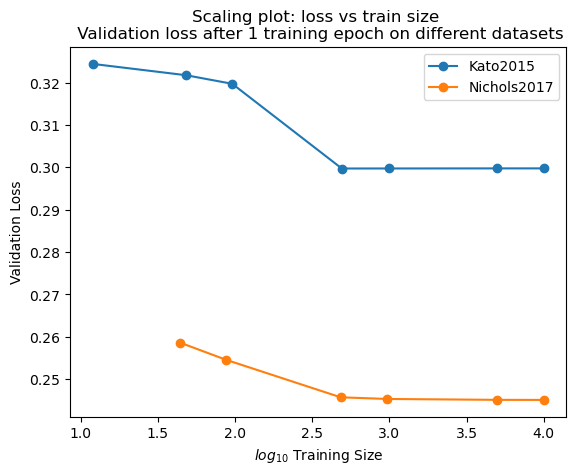

In [178]:
plot_loss_vs_parameter("../logs/hydra", "train.train_size", "dataset.name")